In [248]:
import os
import sys
sys.path.insert(0, os.path.abspath('../model'))
import imp

import numpy as np
import networkx as nx
import json
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import random
import seaborn as sns
from collections import Counter

import copy
#from scipy.special import softmax
#import scipy.stats as ss

#import graph_manager
#imp.reload(graph_manager)
#import relevant_goal_information
#imp.reload(relevant_goal_information)

In [2]:
DF = pd.read_csv("../data/processed/experiment2.csv",index_col=0)
DF = DF.iloc[1:][np.diff(DF.time) != 0]
DF.loc[DF.exp_type == 2,['x','y']] = DF.loc[DF.exp_type == 2,['y','x']].values
DF.loc[DF.exp_type == 2,['box_x','box_y']] = DF.loc[DF.exp_type == 2,['box_y','box_x']].values
DF = DF[~((DF.subject=="319_gtg_a1") & (DF.exp_type==2) & (DF.trial==20) & (DF.dsp_goal==13))]

In [4]:
H = graph_manager.load_graph(filename="map_low.json",filedir="../data/processed/")
old_coord2state = {(x,y):node for node,(x,y) in H.pos.items()}
G = graph_manager.load_graph(filename="map_high.json",filedir="../data/processed/")
coord2state = {(x,y):node for node,(x,y) in G.pos.items()}
state2coord = {node:[x,y] for node,(x,y) in G.pos.items()}

with open('../data/processed/node_labels.json', 'r') as f:
    labels = json.load(f)

In [5]:
def moving_average(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:] / n


def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [6]:
n = 20
v_start_thresh = 10.    # velocity threshold for start of movement
sub_coord_dsp = {}
for dsp in DF.dsp_goal.unique():
    sub_coord = {}
    _DF = DF[DF.dsp_goal == dsp]
    for subject in _DF.subject.unique():


        df = _DF[_DF.subject == subject]
        if df.time.iloc[-1] < 39.5:
            vx = np.diff(df.x)/np.diff(df.time)
            vx = moving_average(vx,n=n)
            vy = np.diff(df.y)/np.diff(df.time)
            vy = moving_average(vy,n=n)
            vs = np.sqrt(vx**2 + vy**2)

            x = moving_average(df.x.to_numpy()[:-1],n=n)
            y = moving_average(df.y.to_numpy()[:-1],n=n)
            
            l = []
            for bx,by in zip(*(df.box_x,df.box_y)):
                l.append(labels[old_coord2state[bx,by]])
            l = l[n:]
            
            for i,v in enumerate(vs):
                if v >= v_start_thresh:
                    break
                    
            angle = np.unwrap(df.angle.to_numpy(),period=360)
            angle_v = np.diff(angle)/np.diff(df.time)
            angle_v = moving_average(angle_v,n=n)
            angle = moving_average(angle,n=n)[:-1]

            sub_coord[subject] = np.array([x[i:],y[i:],vx[i:],vy[i:],vs[i:],l[i:],angle[i:],angle_v[i:]]).T
    sub_coord_dsp[dsp] = sub_coord

Text(0.5, 0, 'Time (s)')

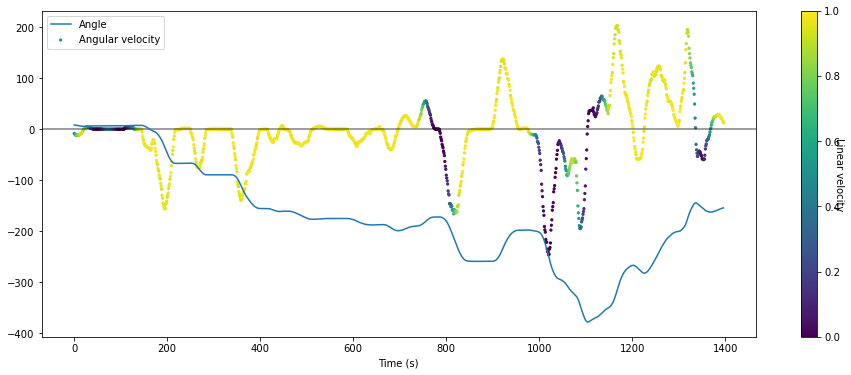

In [14]:
dsp = 19
subject = list(sub_coord.keys())[45]

x,y,vx,vy,vs,l,angle,angle_v = sub_coord_dsp[dsp][subject].T

plt.figure(figsize=(16,6))
plt.axhline(0,color="k",alpha=0.5)
plt.plot(angle,label="Angle")
vmax = vs.max()
plt.scatter(range(len(angle_v)),angle_v,label="Angular velocity",s=5,
            color=plt.cm.viridis(vs/vmax))
cbar = plt.colorbar()
cbar.ax.set_ylabel('Linear velocity', rotation=270)
plt.legend()
plt.xlabel("Time (s)")

Dark points far from the horizontal black line show events where the subject slowed down to look around

In [15]:
xmax,ymax = max(list(H.pos.values()))
maze = np.ones((xmax+1,ymax+1))

for (i,j) in list(H.pos.values()):
    maze[i,j] = 0.
maze = np.array(maze)

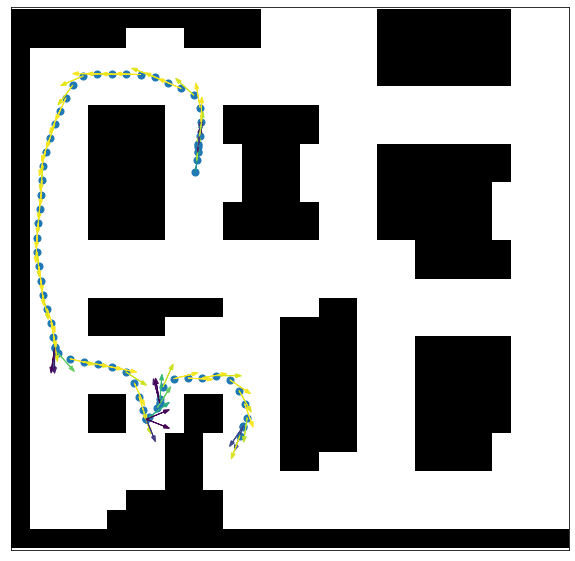

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(maze.T,origin="lower",cmap="Greys")
vmax = vs.max()
plt.scatter(x[::20]/8,y[::20]/8,s=50)
for i,_ in enumerate(x[::20]):
    #plt.arrow(x[i*20]/8,y[i*20]/8,vx[i*20]/16,vy[i*20]/16,color="red",head_width=0.2)
    plt.arrow(x[i*20]/8,y[i*20]/8,np.sin(angle[i*20]*np.pi/180),np.cos(angle[i*20]*np.pi/180),
              color=plt.cm.viridis(vs[i*20]/vmax),head_width=0.2)
plt.axis("equal")
plt.xticks([])
plt.yticks([])

plt.grid(None)

In [17]:
X = []
for dsp in sub_coord_dsp.keys():
    sub_coord = sub_coord_dsp[dsp]
    for key in sub_coord.keys():
        X.extend(sub_coord[key])
X = np.array(X)

In [19]:
threshold = 1.  # linear velocity threshold for being considered stationary
low_v_idxs = np.argwhere(X[:,4]<threshold).T[0]

ang_speed_threshold = 10.   # likewise, but for angular velocity threshold

# get the indices of the points where both threshold are met (stationary and high ang vel) to find VTE points
VTE_idxs = np.argwhere((X[:,4]<threshold) & (np.abs(X[:,7])>ang_speed_threshold)).T[0]

In [24]:
labels_count_all = Counter(X[:,5])
labels_count_VTE = Counter(X[VTE_idxs,5])

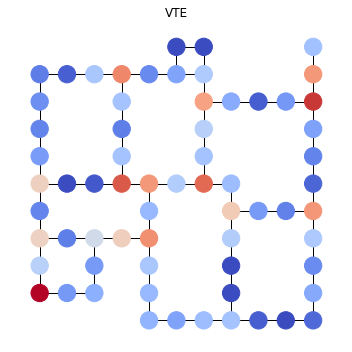

In [170]:
# we normalized the VTE for the effective occupancy of each state

VTE = np.array([labels_count_VTE[key]/labels_count_all[key] if 
                   (key in np.array(sorted(list(labels_count_all.keys())),dtype="int")) else 0
                  for key in G ])
VTE[-1] = VTE.mean()
VTE = (VTE-VTE.min())
VTE = VTE/VTE.max()


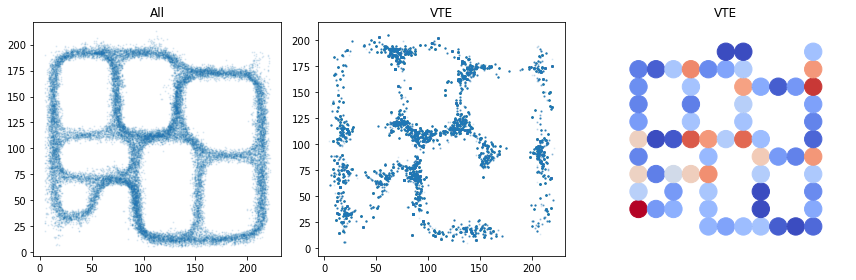

In [192]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title("All")
plt.scatter(X[::100,0],X[::100,1],alpha=.1,s=1)
plt.axis("equal")

plt.subplot(132)
plt.title("VTE")
plt.scatter(X[VTE_idxs,0],X[VTE_idxs,1],alpha=.1,s=1)
plt.axis("equal")

plt.subplot(133)
plt.title("VTE")
nx.draw(G,G.pos,node_color=plt.cm.coolwarm(VTE))
plt.axis("equal")
plt.tight_layout()

plt.show()

In [30]:
I, hist = relevant_goal_information.get_RGI(G,n_steps=150)

In [36]:
ignore = [62,63,64,65,7]    # ignore these states because they were artificially added to the map (but never visited by subjects)
not_ignore = [i for i,_ in enumerate(labels_count_all) if i not in ignore]

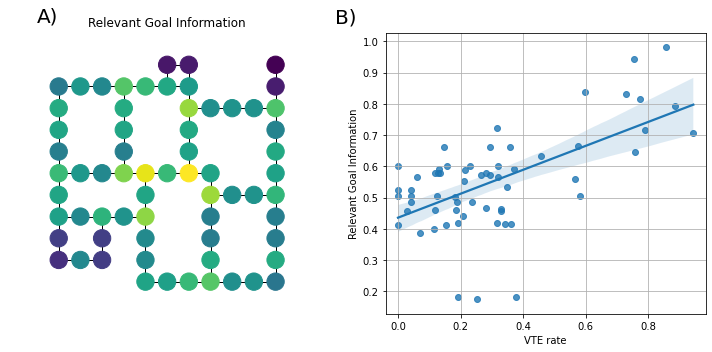

(0.6048423238313564, 2.4345698227781214e-07)


In [160]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title("Relevant Goal Information")
nx.draw(G,G.pos,node_color=I)
plt.axis("equal")
plt.text(-1,12,"A)",fontsize=20)


plt.subplot(122)
plt.xlabel("VTE rate")
plt.ylabel("Relevant Goal Information")
sns.regplot(x=VTE[not_ignore],y=I[not_ignore])
plt.axis("equal")
plt.tight_layout()
plt.grid(zorder=10)
plt.text(-0.2,1.06,"B)",fontsize=20)

plt.tight_layout()
plt.savefig("out/Fig5.png",dpi=300)
plt.show()

print(ss.pearsonr(VTE[not_ignore],I[not_ignore]))

In [61]:
final = pd.read_excel("../data/processed/subjects_state_actions_wm.xlsx")
final["CI/NStatesVisited"] = final.apply(lambda row: row.control_info/row.n_states_visited, axis=1)

In [101]:
def mean_str(col):
    if pd.api.types.is_numeric_dtype(col):
        return col.mean()
    else:
        return col.unique() if col.nunique() == 1 else np.NaN

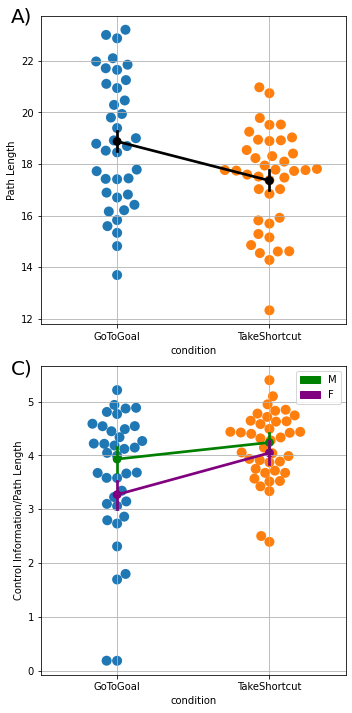

In [161]:
plt.figure(figsize=(5,10))

plt.subplot(211)
sns.pointplot(x="condition", y="n_states_visited", data=final, errobars="sd", color="k", zorder=10)
sns.swarmplot(x="condition", y="n_states_visited", data=final.groupby("subj").agg(mean_str), s=10, zorder=0)

plt.ylabel("Path Length")
plt.grid()
plt.tight_layout()
plt.text(-0.7,23.5,"A)",fontsize=20)

plt.subplot(212)
sns.pointplot(x="condition", y="CI/NStatesVisited", data=final[final.gender == 0], 
    errobars="sd", color="green", zorder=15, label="M")
sns.pointplot(x="condition", y="CI/NStatesVisited", data=final[final.gender == 1], 
    errobars="sd", color="purple", zorder=15, label="F")
sns.swarmplot(x="condition", y="CI/NStatesVisited", data=final.groupby("subj").agg(mean_str), s=10, zorder=-1)


patch1 = matplotlib.patches.Patch(color='green', label='M')
patch2 = matplotlib.patches.Patch(color='purple', label='F')
plt.legend(handles=[patch1, patch2])

plt.ylabel("Control Information/Path Length")
plt.grid()
plt.tight_layout()
plt.text(-0.7,5.5,"C)",fontsize=20)

plt.savefig("out/Fig6AB.png",dpi=300)

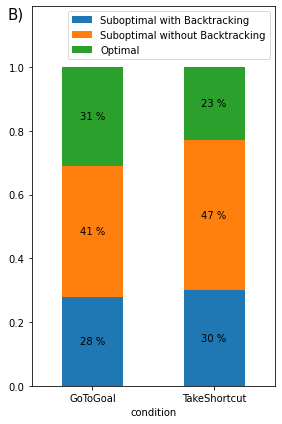

In [169]:
ax = pd.DataFrame([[0.28,0.41,0.31],[0.30,0.47,0.23]],
             columns=["Suboptimal with Backtracking","Suboptimal without Backtracking","Optimal"],
             index=["GoToGoal","TakeShortcut"]).plot.bar(stacked=True,rot=0,figsize=(4,6))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f} %'.format(height*100), 
            horizontalalignment='center', 
            verticalalignment='center')
plt.ylim([0,1.19])
plt.xlabel("condition")
plt.tight_layout()
plt.text(-0.7,1.15,"B)",fontsize=15)
plt.savefig("out/Fig6B.png",dpi=300)

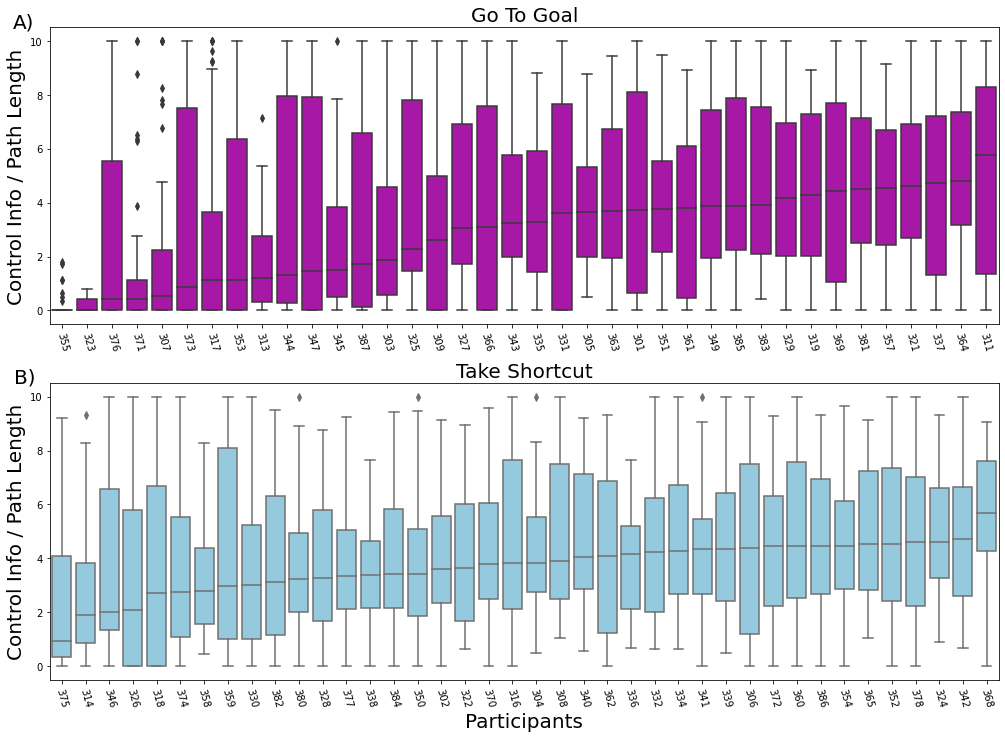

In [233]:
plt.figure(figsize=(17,12))
fontsize = 20

_final = final[final.subj != 315]
_final = _final[_final.subj != 367]

plt.subplot(211)
plt.title("Go To Goal", fontsize=fontsize)
grouped = _final[_final.condition == "GoToGoal"].groupby('subj')
subj_sorted = (
    pd.DataFrame({col: vals['CI/NStatesVisited'] for col, vals in grouped})
    .median()
    .sort_values(ascending=True)
)

sns.boxplot(x="subj", y="CI/NStatesVisited", 
            data=_final, order = subj_sorted.index, color="m")
plt.xticks(rotation=-75)
plt.xlabel("")
plt.ylabel("Control Info / Path Length", fontsize=fontsize)

plt.text(-2, 10.5, "A)", fontsize=20)



grouped = _final[_final.condition == "TakeShortcut"].groupby('subj')
subj_sorted = (
    pd.DataFrame({col: vals['CI/NStatesVisited'] for col, vals in grouped})
    .median()
    .sort_values(ascending=True)
)

plt.subplot(212)
plt.title("Take Shortcut", fontsize=fontsize)
sns.boxplot(x="subj", y="CI/NStatesVisited", 
            data=_final, order = subj_sorted.index, color="skyblue")
plt.xticks(rotation=-75)
plt.xlabel("Participants", fontsize=fontsize)
plt.ylabel("Control Info / Path Length", fontsize=fontsize)

plt.text(-2, 10.5, "B)", fontsize=20)

plt.savefig("out/Fig7.png",dpi=300)

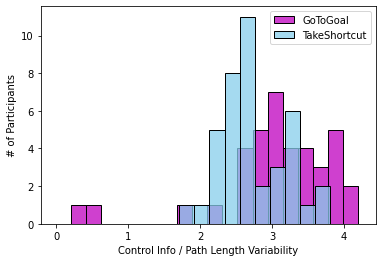

In [244]:
_final = final[final.subj != 315]
_final = _final[_final.subj != 367]

sns.histplot(_final[_final.condition == "GoToGoal"].groupby('subj').std()['CI/NStatesVisited'],
color="m", label="GoToGoal", binrange=(0,4.2), bins=20)
sns.histplot(_final[_final.condition == "TakeShortcut"].groupby('subj').std()['CI/NStatesVisited'],
color="skyblue", label="TakeShortcut", binrange=(0.03,4.23), bins=20)

plt.legend()
plt.xlabel("Control Info / Path Length Variability")
plt.ylabel("# of Participants")
plt.savefig("out/S6.png",dpi=300)

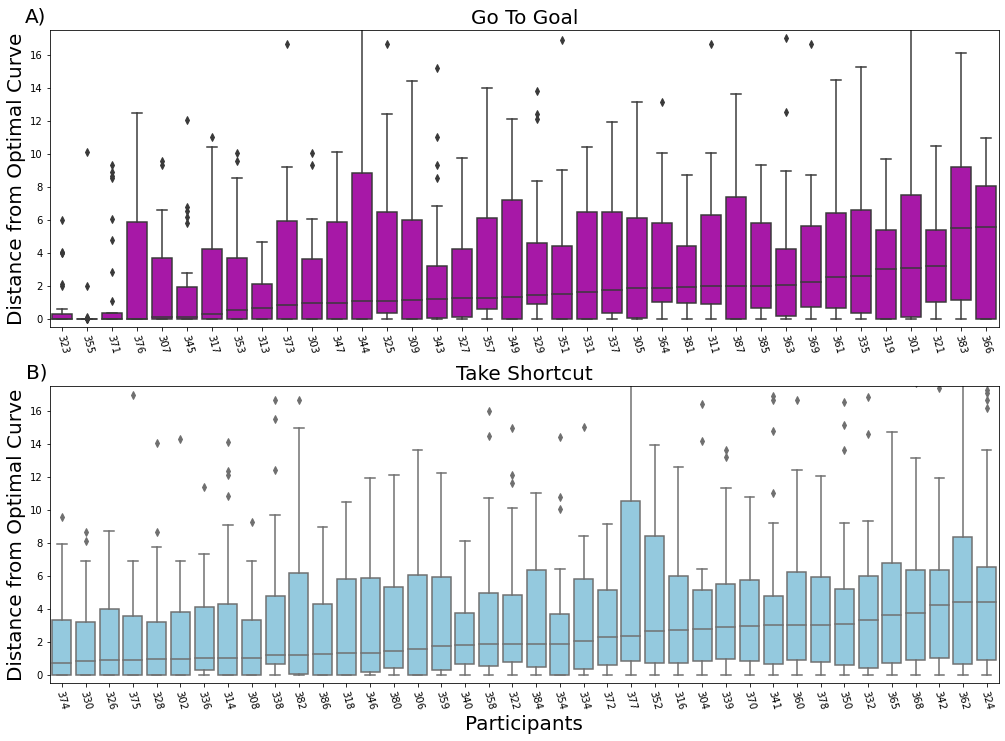

In [236]:
plt.figure(figsize=(17,12))
fontsize = 20

_final = final[final.condition == "GoToGoal"]
_final = _final[_final.subj != 315]
_final = _final[_final.subj != 367]

grouped = _final.groupby('subj')
subj_sorted = (
    pd.DataFrame({col: vals['dist2thcurve'] for col, vals in grouped})
    .median()
    .sort_values(ascending=True)
)
plt.subplot(211)
sns.boxplot(x="subj", y="dist2thcurve",
            data=_final, order = subj_sorted.index, color="m")
plt.xticks(rotation=-75)
plt.ylim([-0.5,17.5])
plt.ylabel("Distance from Optimal Curve", fontsize=fontsize)
plt.title("Go To Goal", fontsize=fontsize)
plt.xlabel("")
plt.text(-1.5,18,"A)",fontsize=20)



_final = final[final.condition == "TakeShortcut"]
_final = _final[_final.subj != 315]
_final = _final[_final.subj != 367]
grouped = _final.groupby('subj')
subj_sorted = (
    pd.DataFrame({col: vals['dist2thcurve'] for col, vals in grouped})
    .median()
    .sort_values(ascending=True)
)
plt.subplot(212)
sns.boxplot(x="subj", y="dist2thcurve",
            data=_final, order = subj_sorted.index, color="skyblue")
plt.xticks(rotation=-75)
plt.ylim([-0.5,17.5])
plt.xlabel("Participants", fontsize=fontsize)
plt.ylabel("Distance from Optimal Curve", fontsize=fontsize)
plt.title("Take Shortcut", fontsize=fontsize)
#plt.show()
plt.text(-1.5,18,"B)", fontsize=20)


plt.savefig("out/S5.png", dpi=300)